In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [2]:
df_train=pd.read_csv('train.csv')

In [3]:
df_train.head(5)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [4]:
df_train.isnull().sum()

id                                                   0
teacher_id                                           0
teacher_prefix                                       4
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 175706
project_essay_4                                 175706
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

We have a total of 1.8 L project proposals and 16 different raw features for each of the proposal. Project eassay 3 and essay 4 are dropped from the requirement recently, so they are missing in most of the proposals.

In [5]:
df_train.shape

(182080, 16)

In [6]:
df_train['project_is_approved'].mean()

0.8476823374340949

Text(0,0.5,u'Frequency')

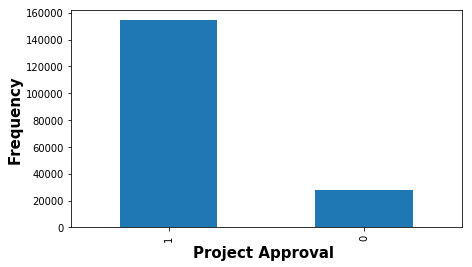

In [11]:
fig1=plt.figure(figsize=(7,4))
ax1=fig1.add_subplot(1,1,1)
df_train['project_is_approved'].value_counts().plot(kind='bar',axes=ax1)
ax1.set_xlabel("Project Approval ",fontsize=15,weight='bold')
ax1.set_ylabel("Frequency",fontsize=15,weight='bold')

84% of the projects are approved.There is imbalance in the data. In such cases, accuracy is not the right metric to evaluate the performance of the classifier. 
ROC curve will have true positive rate on the y axis and flase positive rate of y axis and is plotted for different threshold probabilities. Area under this ROC curve is the best indication of classifier peformance. AUC of 1 indicates a classifier which identifies all the positives correctly and doesn't have any false positives,which is an ideal state. On the other hand , AUC of 0 indicates a classifier which identifies positives and negatives and negatives as positives. This is also a good classfier but we need to reverse the label of it's prediction.

AUC 0.5 is classifier which is not helpful at all, in this case, half of the rows identified as positive by the classifier are negative which is not useful at all. The goal of the improving any machine learning algorithm is to push it's AUC towards 1. Once an optimal AUC is reached, the classifier can be calibrated and a threshold probability can be identified to maximize true positives and minimize false positives.

In [12]:
df_test=pd.read_csv('test.csv')

In [13]:
df_test.head(5)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects
0,p233245,5724a0c3ce11008366fff36dab4b943c,Ms.,CA,2016-04-27 13:45:41,Grades PreK-2,Music & The Arts,Visual Arts,Art Will Make You Happy!,My 2nd grade students are amazing! They are v...,My class is made up of 12 boys and 12 girls. ...,My second grade class will really benefit from...,The genorous donations to my project will make...,My students need a drying rack for their art p...,2
1,p096795,445619941dc7cbe81c7be109dc61a56a,Mrs.,SC,2016-04-28 12:43:56,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Keeping up with the TIMEs,Students within the classroom work in small gr...,My students are all very talented young indivi...,"We do a lot of small group, where the student ...",This project is very important to my classroom...,My students need Time Magazines for next year ...,1
2,p236235,e92a4902b1611a189643d6f12c51e6a0,Mrs.,SC,2016-04-29 21:16:05,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Building Bridges to Problem Solving,My students share a love of learning. These s...,My class consists of 14 energetic learners. O...,These Fairy Tale Problem Solving STEM kits wil...,These materials will be help my students with ...,My students need to be mentally stimulated to ...,0
3,p233680,8e92622d2985d3faac1de71609c4be72,Mrs.,IA,2016-04-27 22:32:43,Grades PreK-2,Literacy & Language,Literacy,Classroom Library,Reading is the gateway to the soul. Guiding c...,First graders enter the classroom each day rea...,Book bins will help to organize our classroom ...,"When students begin the first grade, many are ...",My students need an organized classroom library.,0
4,p171879,91a3c89981f626d9a0d067c65fb186ce,Mr.,CA,2016-04-27 18:59:15,Grades 6-8,"Music & The Arts, Special Needs","Performing Arts, Special Needs",Reeds so we can Read,"\""Mr. Reyes! I need another reed!\"" I hear t...",We have a diverse population with almost entir...,Each day in my class students consume supplies...,My students come from very troubled homes and ...,My students need reeds to perform in class eac...,1


In [14]:
df_test.isnull().sum()

id                                                  0
teacher_id                                          0
teacher_prefix                                      1
school_state                                        0
project_submitted_datetime                          0
project_grade_category                              0
project_subject_categories                          0
project_subject_subcategories                       0
project_title                                       0
project_essay_1                                     0
project_essay_2                                     0
project_essay_3                                 75331
project_essay_4                                 75331
project_resource_summary                            0
teacher_number_of_previously_posted_projects        0
dtype: int64

For extracting text features, we are concating both the test and train data 

In [15]:
df_total=pd.concat([df_train,df_test],axis=0,ignore_index=True)

In [16]:
df_total.head(5)

,id,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_grade_category,project_is_approved,project_resource_summary,project_subject_categories,project_subject_subcategories,project_submitted_datetime,project_title,school_state,teacher_id,teacher_number_of_previously_posted_projects,teacher_prefix
0,p036502,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,Grades PreK-2,1.0,My students need 6 Ipod Nano's to create and d...,Literacy & Language,Literacy,2016-11-18 14:45:59,Super Sight Word Centers,NV,484aaf11257089a66cfedc9461c6bd0a,26,Ms.
1,p039565,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,Grades 3-5,0.0,My students need matching shirts to wear for d...,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",2017-04-26 15:57:28,Keep Calm and Dance On,GA,df72a3ba8089423fa8a94be88060f6ed,1,Mrs.
2,p233823,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,Grades 3-5,1.0,My students need the 3doodler. We are an SEM s...,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",2017-01-01 22:57:44,Lets 3Doodle to Learn,UT,a9b876a9252e08a55e3d894150f75ba3,5,Ms.
3,p185307,My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,Grades 3-5,0.0,My students need balls and other activity equi...,Health & Sports,Health & Wellness,2016-08-12 15:42:11,"\""Kid Inspired\"" Equipment to Increase Activit...",NC,525fdbb6ec7f538a48beebaa0a51b24f,16,Mr.
4,p013780,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,Grades 6-8,1.0,My students need a water filtration system for...,Health & Sports,Health & Wellness,2016-08-06 09:09:11,We need clean water for our culinary arts class!,CA,a63b5547a7239eae4c1872670848e61a,42,Mr.


In [17]:
df_total.isnull().sum()

id                                                   0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 251037
project_essay_4                                 251037
project_grade_category                               0
project_is_approved                              78035
project_resource_summary                             0
project_subject_categories                           0
project_subject_subcategories                        0
project_submitted_datetime                           0
project_title                                        0
school_state                                         0
teacher_id                                           0
teacher_number_of_previously_posted_projects         0
teacher_prefix                                       5
dtype: int64

In [18]:
df_total['Category']='Train'
df_total['Category'][df_total['project_is_approved'].isnull()]='Test'

Resources file contains all the resources requested by each project and connected to projects by key 'id'.

In [19]:
df_resources=pd.read_csv("resources.csv")

In [20]:
df_resources.head(10)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95
5,p069063,Last to Finish: A Story About the Smartest Boy...,1,16.99
6,p069063,"Mrs. Gorski, I Think I Have the Wiggle Fidgets...",1,9.95
7,p069063,"See-N-Read 1503905CQ Reading Tool - Book Size,...",2,10.11
8,p096795,"Brewster WPD90218 Wall Pops Flirt Dot, Set of ...",2,9.95
9,p096795,Brewster Wall Pops WPE99065 Peel & Stick Calyp...,2,9.02


In [21]:
df_resources.isnull().sum()

id               0
description    292
quantity         0
price            0
dtype: int64

** Feature Engineering from resource file **

The resource file has project id, description ,quantity and price as the raw features. In addition to these raw features, 
we are creating additional features such as HighestItemcost,HighestPriceItem,TotalCost,Total number of items, types of items, 
number of words in description.

We will give these features to machine learning model and will let it select them based on value they are adding to classification.

In [22]:
df_resources['Items_Cost']=df_resources['quantity']*df_resources['price']

In [23]:
df_resources['Highest_Item_total_Cost']=df_resources.groupby('id')['Items_Cost'].transform(lambda x : max(x))

In [24]:
df_resources['Highest_Price_Item']=df_resources.groupby('id')['price'].transform(lambda x : max(x))

In [25]:
df_resources['Total_Cost']=df_resources.groupby('id')['Items_Cost'].transform(lambda x : sum(x))

In [26]:
df_resources['Total_Items']=df_resources.groupby('id')['quantity'].transform(lambda x: sum(x))

In [27]:
df_resources['Types_Items']=df_resources.groupby('id')['description'].transform(lambda x :len(x))

In [28]:
df_resources['Description_text']=df_resources.groupby('id')['description'].transform(lambda x : "".join(str(x)))

In [29]:
df_resources['Description_Words']=df_resources['description'].apply(lambda x : len(str(x).split(" ")))

In [30]:
df_resources['Total_Description_Words']=df_resources.groupby('id')['Description_Words'].transform(lambda x : sum(x))

In [31]:
df_resources.head(10)

,id,description,quantity,price,Items_Cost,Highest_Item_total_Cost,Highest_Price_Item,Total_Cost,Total_Items,Types_Items,Description_text,Description_Words,Total_Description_Words
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00,149.00,149.00,149.00,149.00,1,1,0 LC652 - Lakeshore Double-Space Mobile Dry...,7,7
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95,44.85,74.85,24.95,202.49,13,7,1 Bouncy Bands for Desks (Blue suppor...,7,78
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45,8.45,74.85,24.95,202.49,13,7,1 Bouncy Bands for Desks (Blue suppor...,9,78
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59,27.18,74.85,24.95,202.49,13,7,1 Bouncy Bands for Desks (Blue suppor...,11,78
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95,74.85,74.85,24.95,202.49,13,7,1 Bouncy Bands for Desks (Blue suppor...,10,78
5,p069063,Last to Finish: A Story About the Smartest Boy...,1,16.99,16.99,74.85,24.95,202.49,13,7,1 Bouncy Bands for Desks (Blue suppor...,16,78
6,p069063,"Mrs. Gorski, I Think I Have the Wiggle Fidgets...",1,9.95,9.95,74.85,24.95,202.49,13,7,1 Bouncy Bands for Desks (Blue suppor...,15,78
7,p069063,"See-N-Read 1503905CQ Reading Tool - Book Size,...",2,10.11,20.22,74.85,24.95,202.49,13,7,1 Bouncy Bands for Desks (Blue suppor...,10,78
8,p096795,"Brewster WPD90218 Wall Pops Flirt Dot, Set of ...",2,9.95,19.90,200.40,9.95,238.34,44,3,"8 Brewster WPD90218 Wall Pops Flirt Dot, S...",10,38
9,p096795,Brewster Wall Pops WPE99065 Peel & Stick Calyp...,2,9.02,18.04,200.40,9.95,238.34,44,3,"8 Brewster WPD90218 Wall Pops Flirt Dot, S...",13,38


In [32]:
df_resources.drop_duplicates('id',keep='first',inplace=True)

In [33]:
del(df_resources['description'])
del(df_resources['quantity'])
del(df_resources['price'])

In [34]:
del(df_resources['Items_Cost'])

In [35]:
del(df_resources['Types_Items'])
del(df_resources['Description_Words'])

In [36]:
df_resources.head(10)

,id,Highest_Item_total_Cost,Highest_Price_Item,Total_Cost,Total_Items,Description_text,Total_Description_Words
0,p233245,149.00,149.00,149.00,1,0 LC652 - Lakeshore Double-Space Mobile Dry...,7
1,p069063,74.85,24.95,202.49,13,1 Bouncy Bands for Desks (Blue suppor...,78
8,p096795,200.40,9.95,238.34,44,"8 Brewster WPD90218 Wall Pops Flirt Dot, S...",38
11,p149007,504.00,7.99,1078.44,252,"11 Ahora, Spanish, Grades 6 - 12, Level 2 (...",56
14,p236235,298.00,149.00,298.00,2,14 PP440X - Fairy Tales Problem Solving STE...,8
15,p052460,129.00,129.00,516.00,4,15 DD165AT - Calming Colors&#174; Easy-Clea...,40
19,p233680,149.00,149.00,350.66,35,19 AA758BU - Connect & Store Book Bin...,91
30,p245718,599.96,149.99,599.96,4,30 Lifetime 60054 Convertible Bench / Table...,9
31,p171879,146.97,70.39,393.62,8,"31 Alto Saxophone Reeds, Box of 25\n32 ...",18
34,p163637,262.40,17.99,298.38,42,"34 Sold\n35 Sold CD\nName: p163637, d...",3


merging resource features data frame with main project level data frame 

In [37]:
df_total_resour=pd.merge(df_total,df_resources,how='left',left_on='id',right_on='id')

In [38]:
df_total_resour.head(5)

,id,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_grade_category,project_is_approved,project_resource_summary,project_subject_categories,project_subject_subcategories,...,teacher_id,teacher_number_of_previously_posted_projects,teacher_prefix,Category,Highest_Item_total_Cost,Highest_Price_Item,Total_Cost,Total_Items,Description_text,Total_Description_Words
0,p036502,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,Grades PreK-2,1.0,My students need 6 Ipod Nano's to create and d...,Literacy & Language,Literacy,...,484aaf11257089a66cfedc9461c6bd0a,26,Ms.,Train,449.97,149.99,899.94,6,975115 Apple - iPod nano� 16GB MP3 Player (...,28
1,p039565,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,Grades 3-5,0.0,My students need matching shirts to wear for d...,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",...,df72a3ba8089423fa8a94be88060f6ed,1,Mrs.,Train,400.00,20.00,400.00,20,1515020 Reebok Girls' Fashion Dance Graphic...,13
2,p233823,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,Grades 3-5,1.0,My students need the 3doodler. We are an SEM s...,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",...,a9b876a9252e08a55e3d894150f75ba3,5,Ms.,Train,469.99,469.99,469.99,1,1219470 3doodler Start Full Edu Bundle\nNam...,5
3,p185307,My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,Grades 3-5,0.0,My students need balls and other activity equi...,Health & Sports,Health & Wellness,...,525fdbb6ec7f538a48beebaa0a51b24f,16,Mr.,Train,354.99,354.99,684.47,5,502364 BALL PG 4'' POLY SET OF 6 COLORS\...,27
4,p013780,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,Grades 6-8,1.0,My students need a water filtration system for...,Health & Sports,Health & Wellness,...,a63b5547a7239eae4c1872670848e61a,42,Mr.,Train,711.00,355.50,711.00,2,567771 Crown Berkey Water Filter With 2 Bla...,12


In [39]:
df_total_resour.isnull().sum()

id                                                   0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 251037
project_essay_4                                 251037
project_grade_category                               0
project_is_approved                              78035
project_resource_summary                             0
project_subject_categories                           0
project_subject_subcategories                        0
project_submitted_datetime                           0
project_title                                        0
school_state                                         0
teacher_id                                           0
teacher_number_of_previously_posted_projects         0
teacher_prefix                                       5
Category                                             0
Highest_Item_total_Cost                              0
Highest_Pr

** Feature engineering on total data frame **

Presence of Essay 4 and Essay 3 is taken as a new feature

In [40]:
df_total_resour['Essay4_Present']=1
df_total_resour['Essay4_Present'][df_total_resour['project_essay_4'].isnull()]=0
df_total_resour['Essay3_Present']=1
df_total_resour['Essay3_Present'][df_total_resour['project_essay_3'].isnull()]=0

In [41]:
df_total_resour['teacher_prefix'].value_counts()

Mrs.       136387
Ms.         92651
Mr.         25462
Teacher      5569
Dr.            41
Name: teacher_prefix, dtype: int64

In [42]:
df_total_resour['teacher_prefix'][df_total_resour['teacher_prefix'].isnull()]='Mrs.'

Number of words in Essay 1, Essay2,Essay3,Essay4

In [43]:
df_total_resour['Essay_1_words']=df_total_resour['project_essay_1'].apply(lambda x : len(str(x).split(" ")))
df_total_resour['Essay_2_words']=df_total_resour['project_essay_2'].apply(lambda x : len(str(x).split(" ")))
df_total_resour['Essay_3_words']=df_total_resour['project_essay_3'].apply(lambda x : len(str(x).split(" ")))
df_total_resour['Essay_4_words']=df_total_resour['project_essay_4'].apply(lambda x : len(str(x).split(" ")))

In [44]:
df_total_resour[['Essay_1_words','Essay_2_words','Essay_3_words','Essay_4_words']].head(5)

,Essay_1_words,Essay_2_words,Essay_3_words,Essay_4_words
0,170,142,1,1
1,94,102,1,1
2,135,101,1,1
3,206,202,1,1
4,84,108,1,1


Number of words in project title, project resource description

In [45]:
df_total_resour['Project_Title_words']=df_total_resour['project_title'].apply(lambda x : len(x.split(" ")))

In [46]:
df_total_resour['Project_resour_words']=df_total_resour['project_resource_summary'].apply(lambda x : len(x.split(" ")))

** Text Based features **

Till now, we have dealt with text based meta features. Now, we are going to look at word based features from text 

In [47]:
df_total_resour['project_essay_3'][df_total_resour['project_essay_3'].isnull()]=" "
df_total_resour['project_essay_4'][df_total_resour['project_essay_4'].isnull()]=" "

In [48]:
df_total_resour['Total_Text']=df_total_resour['project_essay_1']+df_total_resour['project_essay_2']+df_total_resour['project_essay_3']+df_total_resour['project_essay_4']+df_total_resour['project_resource_summary']+df_total_resour['project_title']+df_total_resour['Description_text']

In [49]:
df_total_resour['Total_Text'].head(10)

0    Most of my kindergarten students come from low...
1    Our elementary school is a culturally rich sch...
2    Hello;\r\nMy name is Mrs. Brotherton. I teach ...
3    My students are the greatest students but are ...
4    My students are athletes and students who are ...
5    My kids tell me each day that they want to mak...
6    Kindergarten is the new first grade. My studen...
7    First graders are fantastic! They are excited ...
8    My seventh graders dream big. They can't wait ...
9    I teach first grade in a small farming town in...
Name: Total_Text, dtype: object

In [50]:
del(df_total_resour['project_essay_1'])
del(df_total_resour['project_essay_2'])
del(df_total_resour['project_essay_3'])
del(df_total_resour['project_essay_4'])
del(df_total_resour['project_resource_summary'])
del(df_total_resour['project_title'])
del(df_total_resour['Description_text'])

Cost deviation from average of category mean 

In [51]:
df_total_resour['Cost_From_group_Average']=df_total_resour.groupby('project_subject_categories')['Total_Cost'].transform(lambda x : x-np.mean(x))

In [52]:
df_total_resour['Cost_From_group_Average'].head(10)

0    432.412235
1   -115.030476
2   -118.625967
3     83.929629
4    110.459629
5    163.919550
6   -186.520371
7   -148.660450
8   -262.664970
9   -347.767765
Name: Cost_From_group_Average, dtype: float64

Cost deviation from average of grade

In [53]:
df_total_resour['Cost_From_Grade_Average']=df_total_resour.groupby('project_grade_category')['Total_Cost'].transform(lambda x : x-np.mean(x))

In [54]:
df_total_resour['Cost_From_Grade_Average'].head(10)

0    414.443282
1   -139.917817
2    -69.927817
3    144.552183
4     95.862007
5    241.863282
6    -71.476718
7    -70.716718
8   -295.337993
9   -365.736718
Name: Cost_From_Grade_Average, dtype: float64

In [55]:
df_total_resour.head(10)

,id,project_grade_category,project_is_approved,project_subject_categories,project_subject_subcategories,project_submitted_datetime,school_state,teacher_id,teacher_number_of_previously_posted_projects,teacher_prefix,...,Essay3_Present,Essay_1_words,Essay_2_words,Essay_3_words,Essay_4_words,Project_Title_words,Project_resour_words,Total_Text,Cost_From_group_Average,Cost_From_Grade_Average
0,p036502,Grades PreK-2,1.0,Literacy & Language,Literacy,2016-11-18 14:45:59,NV,484aaf11257089a66cfedc9461c6bd0a,26,Ms.,...,0,170,142,1,1,4,21,Most of my kindergarten students come from low...,432.412235,414.443282
1,p039565,Grades 3-5,0.0,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",2017-04-26 15:57:28,GA,df72a3ba8089423fa8a94be88060f6ed,1,Mrs.,...,0,94,102,1,1,5,12,Our elementary school is a culturally rich sch...,-115.030476,-139.917817
2,p233823,Grades 3-5,1.0,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",2017-01-01 22:57:44,UT,a9b876a9252e08a55e3d894150f75ba3,5,Ms.,...,0,135,101,1,1,4,33,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,-118.625967,-69.927817
3,p185307,Grades 3-5,0.0,Health & Sports,Health & Wellness,2016-08-12 15:42:11,NC,525fdbb6ec7f538a48beebaa0a51b24f,16,Mr.,...,0,206,202,1,1,10,37,My students are the greatest students but are ...,83.929629,144.552183
4,p013780,Grades 6-8,1.0,Health & Sports,Health & Wellness,2016-08-06 09:09:11,CA,a63b5547a7239eae4c1872670848e61a,42,Mr.,...,0,84,108,1,1,9,12,My students are athletes and students who are ...,110.459629,95.862007
5,p063374,Grades PreK-2,1.0,"Applied Learning, Literacy & Language","Character Education, Literature & Writing",2016-11-05 10:01:51,DE,403c6783e9286e51ab318fba40f8d729,0,Mrs.,...,0,86,118,1,1,7,35,My kids tell me each day that they want to mak...,163.919550,241.863282
6,p103285,Grades PreK-2,1.0,Health & Sports,Health & Wellness,2016-08-31 00:30:43,MO,4e156c5fb3eea2531601c8736f3751a7,1,Mrs.,...,0,133,152,1,1,2,20,Kindergarten is the new first grade. My studen...,-186.520371,-71.476718
7,p181781,Grades PreK-2,1.0,"Applied Learning, Literacy & Language","Early Development, Literature & Writing",2016-08-03 13:26:01,SC,c71f2ef13b4bc91afac61ca8fd4c0f9f,0,Mrs.,...,0,82,101,1,1,4,12,First graders are fantastic! They are excited ...,-148.660450,-70.716718
8,p114989,Grades 6-8,1.0,Math & Science,Mathematics,2016-09-13 22:35:57,IN,b580c11b1497a0a67317763b7f03eb27,13,Ms.,...,0,102,136,1,1,6,33,My seventh graders dream big. They can't wait ...,-262.664970,-295.337993
9,p191410,Grades PreK-2,1.0,Literacy & Language,Literacy,2016-09-24 18:38:59,IL,2071fb0af994f8f16e7c6ed0f35062a1,12,Mrs.,...,0,109,134,1,1,6,11,I teach first grade in a small farming town in...,-347.767765,-365.736718


Naive bayes algorithm is traditionally used for text classification. We will use TfIdf Vectorizer to process the textual part 
of project proposals and on top of that apply Multinominal Naive Bayes algorithm for classification

** Naive Bayes Model on Text features **

In [56]:
X_nb_total=df_total_resour['Total_Text'][df_total_resour['Category']=='Train'].get_values()
Y_nb_total=df_total_resour['project_is_approved'][df_total_resour['Category']=='Train'].get_values()

In [58]:
skf=StratifiedKFold(n_splits=5)
score_old=0
for q in [0.1,0.2,0.3]:
    for p in [0.8,0.9,1.0]:
          for r in [0.01,0.1,1,10]:
            mnb=MultinomialNB(alpha=r)
            TfIdfVect=TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_df=p,min_df=q)
            X_trans=TfIdfVect.fit_transform(X_nb_total)
            score=cross_val_score(mnb,X_trans,Y_nb_total,cv=skf,scoring='roc_auc').mean()
            if score>score_old:
                score_old=score
                print(score)
                q_max=q
                p_max=p
                r_max=r

0.6528938462278165
0.6533938347415693
0.653394198028932
0.6533976053303222


In [59]:
print(" The Best socre with Naive Bayes %.2f is with min_df %.2f max_df %.2f and laplace smoothening %.2f"%(score_old,q_max,p_max,r_max))

 The Best socre with Naive Bayes 0.65 is with min_df 0.10 max_df 1.00 and laplace smoothening 1.00


Naive Bayes classifier is giving AUC of 0.65. However, this model doesn't include other text meta features and pricing features.
Including these features might improve the accuracy much more.

We will use Naive bayes classifier as a feature generator itself. For doing this, we will divide training data into 5 folds, create a model on 4 folds and then predict on 5th fold. This process will repeat for all the five folds.For test set, we will
train the model on training set and create features on test set.

**Naive Bayes feature generation **

In [60]:
df_train2=df_total_resour[['Total_Text','id']][df_total_resour['Category']=='Train']
X_nb_total2=df_total_resour['Total_Text'][df_total_resour['Category']=='Train'].get_values()
Y_nb_total2=df_total_resour['project_is_approved'][df_total_resour['Category']=='Train'].get_values()
df_val2=df_total_resour[['Total_Text','id']][df_total_resour['Category']=='Test']
df_train2.reset_index(drop=True,inplace=True)
df_val2.reset_index(drop=True,inplace=True)
X_nb_val2=df_val2['Total_Text'].get_values()

In [63]:
df_train2['nb_prediction']=np.NaN
skf1=StratifiedKFold(n_splits=5)
for train_index,test_index in skf1.split(X_nb_total2,Y_nb_total2):
     TfIdfVect1=TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_df=1.0,min_df=0.1)
     X_train_transformed=TfIdfVect1.fit_transform(X_nb_total2[train_index])
     X_test_transformed=TfIdfVect1.transform(X_nb_total2[test_index])
     mnb=MultinomialNB(alpha=1)
     mnb.fit(X_train_transformed,Y_nb_total2[train_index])
     prediction=list(mnb.predict_proba(X_test_transformed)[:,1])
     df_train2['nb_prediction'][test_index]=prediction

In [64]:
TfIdfVect2=TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_df=1.0,min_df=0.1)
X_train2_transformed=TfIdfVect2.fit_transform(X_nb_total2)
X_val2_transformed=TfIdfVect2.transform(X_nb_val2)
mnb2=MultinomialNB(alpha=1)
mnb2.fit(X_train2_transformed,Y_nb_total2)
predict2=list(mnb2.predict_proba(X_val2_transformed)[:,1])
df_val2['nb_prediction']=predict2

In [65]:
df_train2.head(10)

,Total_Text,id,nb_prediction
0,Most of my kindergarten students come from low...,p036502,0.869266
1,Our elementary school is a culturally rich sch...,p039565,0.858608
2,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,p233823,0.868872
3,My students are the greatest students but are ...,p185307,0.813494
4,My students are athletes and students who are ...,p013780,0.851573
5,My kids tell me each day that they want to mak...,p063374,0.876591
6,Kindergarten is the new first grade. My studen...,p103285,0.863657
7,First graders are fantastic! They are excited ...,p181781,0.881211
8,My seventh graders dream big. They can't wait ...,p114989,0.883740
9,I teach first grade in a small farming town in...,p191410,0.887563


In [66]:
df_val2.head(10)

,Total_Text,id,nb_prediction
0,My 2nd grade students are amazing! They are v...,p233245,0.846713
1,Students within the classroom work in small gr...,p096795,0.868111
2,My students share a love of learning. These s...,p236235,0.824743
3,Reading is the gateway to the soul. Guiding c...,p233680,0.893788
4,"\""Mr. Reyes! I need another reed!\"" I hear t...",p171879,0.844642
5,A typical day in our classroom can be a little...,p016071,0.894530
6,My students crave engaging texts with which th...,p099906,0.858310
7,My students have to sit around a CD player to ...,p200236,0.864965
8,My students are new to school when they come t...,p129452,0.787668
9,My students have been working on DIY whiteboar...,p186652,0.866512


In [67]:
df_train2.isnull().sum()

Total_Text       0
id               0
nb_prediction    0
dtype: int64

In [68]:
df_val2.isnull().sum()

Total_Text       0
id               0
nb_prediction    0
dtype: int64

In [69]:
df_nb=pd.concat([df_train2,df_val2],axis=0,ignore_index=True)

In [70]:
df_nb=df_nb[['id','nb_prediction']]

In [71]:
df_total_resour=pd.merge(df_total_resour,df_nb,left_on='id',right_on='id',how='outer')

In [72]:
df_total_resour.columns

Index([u'id', u'project_grade_category', u'project_is_approved',
       u'project_subject_categories', u'project_subject_subcategories',
       u'project_submitted_datetime', u'school_state', u'teacher_id',
       u'teacher_number_of_previously_posted_projects', u'teacher_prefix',
       u'Category', u'Highest_Item_total_Cost', u'Highest_Price_Item',
       u'Total_Cost', u'Total_Items', u'Total_Description_Words',
       u'Essay4_Present', u'Essay3_Present', u'Essay_1_words',
       u'Essay_2_words', u'Essay_3_words', u'Essay_4_words',
       u'Project_Title_words', u'Project_resour_words', u'Total_Text',
       u'Cost_From_group_Average', u'Cost_From_Grade_Average',
       u'nb_prediction'],
      dtype='object')

In [73]:
df_total_resour.isnull().sum()

id                                                  0
project_grade_category                              0
project_is_approved                             78035
project_subject_categories                          0
project_subject_subcategories                       0
project_submitted_datetime                          0
school_state                                        0
teacher_id                                          0
teacher_number_of_previously_posted_projects        0
teacher_prefix                                      0
Category                                            0
Highest_Item_total_Cost                             0
Highest_Price_Item                                  0
Total_Cost                                          0
Total_Items                                         0
Total_Description_Words                             0
Essay4_Present                                      0
Essay3_Present                                      0
Essay_1_words               

 Till now we have text based meta features, Naive bayes predictions features.In next steps we are going to compress
the text based features into low dimensional space using LSI and further use them as inputs for machine learning.

** Latent Semantec Indexing **

In [74]:
TfIdfVect3=TfidfVectorizer(stop_words='english')
X_total=TfIdfVect3.fit_transform(df_total_resour['Total_Text'].get_values())

In [75]:
X_total.shape

(260115, 1953046)

In [76]:
SVD=TruncatedSVD(n_components=50,algorithm='arpack')
X_total_text_features=SVD.fit_transform(X_total)

In [77]:
svd_columns=[]
for p in np.arange(50):
    svd_columns.append("svd_"+str(p))

In [78]:
df_total_text_columns=pd.DataFrame(X_total_text_features,columns=svd_columns)

In [79]:
df_total_withsvd=pd.concat([df_total_resour,df_total_text_columns],axis=1)

In [80]:
df_total_withsvd.columns

Index([u'id', u'project_grade_category', u'project_is_approved',
       u'project_subject_categories', u'project_subject_subcategories',
       u'project_submitted_datetime', u'school_state', u'teacher_id',
       u'teacher_number_of_previously_posted_projects', u'teacher_prefix',
       u'Category', u'Highest_Item_total_Cost', u'Highest_Price_Item',
       u'Total_Cost', u'Total_Items', u'Total_Description_Words',
       u'Essay4_Present', u'Essay3_Present', u'Essay_1_words',
       u'Essay_2_words', u'Essay_3_words', u'Essay_4_words',
       u'Project_Title_words', u'Project_resour_words', u'Total_Text',
       u'Cost_From_group_Average', u'Cost_From_Grade_Average',
       u'nb_prediction', u'svd_0', u'svd_1', u'svd_2', u'svd_3', u'svd_4',
       u'svd_5', u'svd_6', u'svd_7', u'svd_8', u'svd_9', u'svd_10', u'svd_11',
       u'svd_12', u'svd_13', u'svd_14', u'svd_15', u'svd_16', u'svd_17',
       u'svd_18', u'svd_19', u'svd_20', u'svd_21', u'svd_22', u'svd_23',
       u'svd_24', u'svd

In [81]:
del(df_total_withsvd['Total_Text'])

We have couple of categorical features in the raw data. We will create on hot encoding for all these categorical features 

** One hot encoding for categorical features **

In [82]:
df_total_withsvd['project_subject_categories']=df_total_withsvd['project_subject_categories'].str.replace(",","")

In [83]:
df_total_withsvd['project_subject_categories']=df_total_withsvd['project_subject_categories'].str.replace("&","")

In [84]:
df_total_withsvd['project_subject_subcategories']=df_total_withsvd['project_subject_subcategories'].str.replace(",","")

In [85]:
df_total_withsvd['project_subject_subcategories']=df_total_withsvd['project_subject_subcategories'].str.replace("&","")

In [86]:
df_categorical=df_total_withsvd[['project_grade_category','project_subject_categories','school_state','teacher_prefix','project_subject_subcategories']]

In [87]:
df_dummies=pd.get_dummies(df_categorical,drop_first=False,prefix=['grade','subject','school','teacher_title','subject_sub'])

In [88]:
del(df_total_withsvd['project_grade_category'])
del(df_total_withsvd['project_subject_categories'])
del(df_total_withsvd['school_state'])
del(df_total_withsvd['teacher_prefix'])

In [89]:
del(df_total_withsvd['project_subject_subcategories'])

Features for month of submission, day of submission 

In [90]:
df_total_withsvd[u'project_submitted_datetime']=pd.to_datetime(df_total_withsvd[u'project_submitted_datetime'])

In [91]:
df_total_withsvd['Submission_Month']=df_total_withsvd[u'project_submitted_datetime'].dt.month

In [92]:
df_total_withsvd['Day_Submission']=df_total_withsvd[u'project_submitted_datetime'].dt.dayofweek

In [93]:
df_dummies_day=pd.get_dummies(df_total_withsvd['Day_Submission'],drop_first=False,prefix="day")

In [94]:
df_dummies_month=pd.get_dummies(df_total_withsvd['Submission_Month'],drop_first=False,prefix="month")

In [95]:
del(df_total_withsvd['project_submitted_datetime'])

In [96]:
df_finalfeatures=pd.concat([df_total_withsvd,df_dummies,df_dummies_month,df_dummies_day],axis=1)

In [97]:
del(df_finalfeatures['Submission_Month'])

In [98]:
del(df_finalfeatures['teacher_id'])

In [99]:
list(df_finalfeatures.columns)

['id',
 'project_is_approved',
 'teacher_number_of_previously_posted_projects',
 'Category',
 'Highest_Item_total_Cost',
 'Highest_Price_Item',
 'Total_Cost',
 'Total_Items',
 'Total_Description_Words',
 'Essay4_Present',
 'Essay3_Present',
 'Essay_1_words',
 'Essay_2_words',
 'Essay_3_words',
 'Essay_4_words',
 'Project_Title_words',
 'Project_resour_words',
 'Cost_From_group_Average',
 'Cost_From_Grade_Average',
 'nb_prediction',
 'svd_0',
 'svd_1',
 'svd_2',
 'svd_3',
 'svd_4',
 'svd_5',
 'svd_6',
 'svd_7',
 'svd_8',
 'svd_9',
 'svd_10',
 'svd_11',
 'svd_12',
 'svd_13',
 'svd_14',
 'svd_15',
 'svd_16',
 'svd_17',
 'svd_18',
 'svd_19',
 'svd_20',
 'svd_21',
 'svd_22',
 'svd_23',
 'svd_24',
 'svd_25',
 'svd_26',
 'svd_27',
 'svd_28',
 'svd_29',
 'svd_30',
 'svd_31',
 'svd_32',
 'svd_33',
 'svd_34',
 'svd_35',
 'svd_36',
 'svd_37',
 'svd_38',
 'svd_39',
 'svd_40',
 'svd_41',
 'svd_42',
 'svd_43',
 'svd_44',
 'svd_45',
 'svd_46',
 'svd_47',
 'svd_48',
 'svd_49',
 'Day_Submission',
 'gra

In [100]:
len(list(df_finalfeatures.columns))

617

Finally we have a total of 617 features. There can be high correlations, non useful features in this list,but we will let the 
classifier choose these features

In [101]:
df_train_final=df_finalfeatures[df_finalfeatures['Category']=='Train']

In [102]:
df_test_final=df_finalfeatures[df_finalfeatures['Category']=='Test']

In [103]:
del(df_train_final['Category'])
del(df_test_final['Category'])

In [104]:
list_features=list(df_finalfeatures.columns)

In [106]:
list_features.remove("id")
list_features.remove("project_is_approved")
list_features.remove("Category")

** Applying XGboost on our model **

In [108]:
X=df_train_final[list_features].get_values()
Y=df_train_final['project_is_approved'].get_values()

In [109]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,stratify=Y,random_state=42)

In [110]:
df_X_train=pd.DataFrame(X_train,columns=list_features)
df_X_test=pd.DataFrame(X_test,columns=list_features)

In [111]:
df_Y_train=pd.DataFrame(Y_train,columns=['Target'])
df_Y_test=pd.DataFrame(Y_test,columns=['Target'])

In [112]:
df_Y_train['Target']=Y_train
df_Y_test['Target']=Y_test

In [113]:
df_Y_train.head(10)

,Target
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [118]:
XGB=XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=1000, silent=False, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=6, max_delta_step=0, subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=0, missing=None)

In [119]:
XGB.fit(df_X_train,df_Y_train,eval_set=[(df_X_train,df_Y_train),(df_X_test,df_Y_test)],eval_metric='auc',early_stopping_rounds=50,verbose=True)

[0]	validation_0-auc:0.696049	validation_1-auc:0.688359
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.715147	validation_1-auc:0.706118
[2]	validation_0-auc:0.718422	validation_1-auc:0.708636
[3]	validation_0-auc:0.723396	validation_1-auc:0.713443
[4]	validation_0-auc:0.724234	validation_1-auc:0.714651
[5]	validation_0-auc:0.725911	validation_1-auc:0.716659
[6]	validation_0-auc:0.726433	validation_1-auc:0.716833
[7]	validation_0-auc:0.727477	validation_1-auc:0.717858
[8]	validation_0-auc:0.728103	validation_1-auc:0.717931
[9]	validation_0-auc:0.72824	validation_1-auc:0.718002
[10]	validation_0-auc:0.72872	validation_1-auc:0.718568
[11]	validation_0-auc:0.730189	validation_1-auc:0.719557
[12]	validation_0-auc:0.73219	validation_1-auc:0.720679
[13]	validation_0-auc:0.733427	validation_1-auc:0.720958
[14]	validation_0-auc:0.734444	validation_1-auc:0.721763
[

[142]	validation_0-auc:0.802185	validation_1-auc:0.751427
[143]	validation_0-auc:0.802373	validation_1-auc:0.751482
[144]	validation_0-auc:0.802617	validation_1-auc:0.751466
[145]	validation_0-auc:0.80278	validation_1-auc:0.751482
[146]	validation_0-auc:0.802977	validation_1-auc:0.751525
[147]	validation_0-auc:0.803186	validation_1-auc:0.751484
[148]	validation_0-auc:0.803433	validation_1-auc:0.751581
[149]	validation_0-auc:0.80367	validation_1-auc:0.751538
[150]	validation_0-auc:0.803911	validation_1-auc:0.751663
[151]	validation_0-auc:0.804157	validation_1-auc:0.751738
[152]	validation_0-auc:0.804364	validation_1-auc:0.751754
[153]	validation_0-auc:0.804615	validation_1-auc:0.751814
[154]	validation_0-auc:0.804979	validation_1-auc:0.751861
[155]	validation_0-auc:0.805085	validation_1-auc:0.751917
[156]	validation_0-auc:0.805306	validation_1-auc:0.751928
[157]	validation_0-auc:0.805576	validation_1-auc:0.752
[158]	validation_0-auc:0.805844	validation_1-auc:0.751987
[159]	validation_0-

[284]	validation_0-auc:0.834975	validation_1-auc:0.753406
[285]	validation_0-auc:0.835161	validation_1-auc:0.753569
[286]	validation_0-auc:0.835341	validation_1-auc:0.753584
[287]	validation_0-auc:0.835583	validation_1-auc:0.753565
[288]	validation_0-auc:0.835728	validation_1-auc:0.753581
Stopping. Best iteration:
[238]	validation_0-auc:0.826362	validation_1-auc:0.753702



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=6, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=False,
       subsample=0.8)

In [120]:
XGB1=XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=238, silent=False, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=6, max_delta_step=0, subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=0, missing=None)

In [121]:
XGB1.fit(df_train_final[list_features],df_train_final['project_is_approved'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=6, missing=None, n_estimators=238,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=False,
       subsample=0.8)

 Since we have large number of features , we need to evaluate their contribution based on their contribution to predictive
model. The feature importances in XGB will give this score. In the next few steps, we will create a data frame having
individual features and their respective score. Also, we will eliminate any feature having a score of zero

In [122]:
df_featimp=pd.DataFrame({'Features':list_features,'Score':list(XGB1.feature_importances_)})

In [123]:
df_featimp.sort_values(by='Score',ascending=False,inplace=True)

In [124]:
df_newfeat=df_featimp[df_featimp['Score']!=0]

In [125]:
df_newfeat

,Features,Score
9,Essay_2_words,0.033860
5,Total_Description_Words,0.033062
17,svd_0,0.028111
16,nb_prediction,0.027631
2,Highest_Price_Item,0.025555
0,teacher_number_of_previously_posted_projects,0.023638
21,svd_4,0.019166
54,svd_37,0.018527
60,svd_43,0.018368
31,svd_14,0.018048


In [126]:
list_new_features=list(df_newfeat['Features'])

In this initial steps of our model building, we have a total of 607 features, after eliminating features with importance score
zero we are left with only 153 features. We will build a new model with these new set of features

In [127]:
XGB2=XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=1000, silent=False, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=6, max_delta_step=0, subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=0, missing=None)

In [128]:
df_X1_train=df_X_train[list_new_features]
df_X1_test=df_X_test[list_new_features]
df_Y1_train=pd.DataFrame(Y_train,columns=['Target'])
df_Y1_test=pd.DataFrame(Y_test,columns=['Target'])
df_Y1_train['Target']=Y_train
df_Y1_test['Target']=Y_test

In [129]:
XGB2.fit(df_X_train,df_Y_train,eval_set=[(df_X_train,df_Y_train),(df_X_test,df_Y_test)],eval_metric='auc',early_stopping_rounds=50,verbose=True)

[0]	validation_0-auc:0.696049	validation_1-auc:0.688359
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.715147	validation_1-auc:0.706118
[2]	validation_0-auc:0.718422	validation_1-auc:0.708636
[3]	validation_0-auc:0.723396	validation_1-auc:0.713443
[4]	validation_0-auc:0.724234	validation_1-auc:0.714651
[5]	validation_0-auc:0.725911	validation_1-auc:0.716659
[6]	validation_0-auc:0.726433	validation_1-auc:0.716833
[7]	validation_0-auc:0.727477	validation_1-auc:0.717858
[8]	validation_0-auc:0.728103	validation_1-auc:0.717931
[9]	validation_0-auc:0.72824	validation_1-auc:0.718002
[10]	validation_0-auc:0.72872	validation_1-auc:0.718568
[11]	validation_0-auc:0.730189	validation_1-auc:0.719557
[12]	validation_0-auc:0.73219	validation_1-auc:0.720679
[13]	validation_0-auc:0.733427	validation_1-auc:0.720958
[14]	validation_0-auc:0.734444	validation_1-auc:0.721763
[

[142]	validation_0-auc:0.802185	validation_1-auc:0.751427
[143]	validation_0-auc:0.802373	validation_1-auc:0.751482
[144]	validation_0-auc:0.802617	validation_1-auc:0.751466
[145]	validation_0-auc:0.80278	validation_1-auc:0.751482
[146]	validation_0-auc:0.802977	validation_1-auc:0.751525
[147]	validation_0-auc:0.803186	validation_1-auc:0.751484
[148]	validation_0-auc:0.803433	validation_1-auc:0.751581
[149]	validation_0-auc:0.80367	validation_1-auc:0.751538
[150]	validation_0-auc:0.803911	validation_1-auc:0.751663
[151]	validation_0-auc:0.804157	validation_1-auc:0.751738
[152]	validation_0-auc:0.804364	validation_1-auc:0.751754
[153]	validation_0-auc:0.804615	validation_1-auc:0.751814
[154]	validation_0-auc:0.804979	validation_1-auc:0.751861
[155]	validation_0-auc:0.805085	validation_1-auc:0.751917
[156]	validation_0-auc:0.805306	validation_1-auc:0.751928
[157]	validation_0-auc:0.805576	validation_1-auc:0.752
[158]	validation_0-auc:0.805844	validation_1-auc:0.751987
[159]	validation_0-

[284]	validation_0-auc:0.834975	validation_1-auc:0.753406
[285]	validation_0-auc:0.835161	validation_1-auc:0.753569
[286]	validation_0-auc:0.835341	validation_1-auc:0.753584
[287]	validation_0-auc:0.835583	validation_1-auc:0.753565
[288]	validation_0-auc:0.835728	validation_1-auc:0.753581
Stopping. Best iteration:
[238]	validation_0-auc:0.826362	validation_1-auc:0.753702



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=6, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=False,
       subsample=0.8)

In [130]:
XGB2.set_params(n_estimators=238)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=6, missing=None, n_estimators=238,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=False,
       subsample=0.8)

In [131]:
XGB2.fit(df_train_final[list_new_features],df_train_final['project_is_approved'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=6, missing=None, n_estimators=238,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=False,
       subsample=0.8)

In [132]:
df_submission=df_test_final[list_new_features]

In [133]:
list_prediction=XGB2.predict_proba(df_submission)

In [134]:
list_id=df_test_final['id']

In [135]:
submission=pd.DataFrame({'id':list_id,'Prediction':list_prediction[:,1]})

In [136]:
submission.head(10)

,Prediction,id
182080,0.937288,p233245
182081,0.932611,p096795
182082,0.940947,p236235
182083,0.853470,p233680
182084,0.877205,p171879
182085,0.963892,p016071
182086,0.909071,p099906
182087,0.866717,p200236
182088,0.745566,p129452
182089,0.962904,p186652


In [137]:
submission.to_csv("submission1.csv")

Our algortihm based on XGB is giving AUC of 0.7537 compared to 0.65 with Naive bayes. We can further imporve our AUC by 
hyperpamater tuning for XGB model.Also,trying Nueral net work model might also help.

To keep this model in production, we need calibrate the probabilities given by XGB model and using ROC curve, we can derive the 
threshold probability that gives optimum true positive rate.